<a href="https://colab.research.google.com/github/khushiiagrawal/LC_gar/blob/main/LangGraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install -U langgraph langsmith

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 13.4 MB/s eta 0:00:00


In [3]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [5]:
pip install -U "langchain[google-genai]"

In [6]:
import os
from langchain.chat_models import init_chat_model

os.environ["GOOGLE_API_KEY"] = "gemini-api-key"

llm = init_chat_model("google_genai:gemini-2.5-flash")

In [7]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

In [8]:
graph_builder.add_edge(START, "chatbot")

In [9]:
graph_builder.add_edge("chatbot", END)

In [10]:
graph = graph_builder.compile()

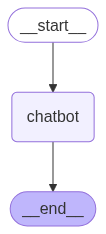

In [11]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: what do you know about langgraph
Assistant: LangGraph is an extension of the LangChain framework, specifically designed to build **stateful, multi-actor, and highly dynamic LLM applications** using a **graph-based approach**.

While LangChain's core `Runnable` interface is excellent for chaining linear sequences of operations (like RAG chains or simple tool use), it struggles with more complex control flow, such as:

*   **Loops:** Where an agent might need to iterate on a task (e.g., try a tool, if it fails, re-plan and try again).
*   **Conditional Logic:** Where the next step depends on the outcome of a previous step (e.g., if a user asks a factual question, go to RAG; if they ask for a code snippet, go to a code generation tool).
*   **Human-in-the-Loop:** Pausing execution for human review or input.
*   **Multi-Agent Orchestration:** Coordinating multiple specialized LLM agents that need to pass information back and forth and decide who acts next.
*   **Persistent State:** M